# ML Lab CS360
## Assignment 5

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from math import sqrt
from math import pi
from math import exp

In [2]:
def XOR():
  X = [[0, 0], [0, 1], [1, 0], [1, 1]]
  y = [0, 1, 1, 0]
  return X, y

def AND():
  X = [[0, 0], [0, 1], [1, 0], [1, 1]]
  y = [0, 0, 0, 1]
  return X, y

mod = lambda x: x if x > 0 else -x

class SLP():
  def __init__(self, input_feats, learning_rate=1e-5):
    self._weights = np.random.default_rng().uniform(low=-0.3, high=0.3, size=(input_feats+1, 1))
    self._lr = learning_rate

  def __activation(self, z):
    y = z
    y[y >= 0] = 1
    y[y < 0] = 0
    return y

  def __set_shape(self, array):
    array = np.asarray(array)
    if array.ndim == 1:
      return np.reshape(array, newshape=(-1, 1))
    elif array.ndim == 2:
      return array
    else:
      raise error

  def __add_bias(self, X):
    m = X.shape[0]
    return np.c_[np.ones(m), X]

  def predict(self, X):
    z = X @ self._weights
    return self.__activation(z)

  def __epoch(self, X, y):
    error = 0
    for i in range(X.shape[0]):
      delt = y[i] - self.predict(X[i])
      delt = delt.item()
      x = np.reshape(X[i], newshape=(-1, 1))
      self._weights = self._weights + self._lr * delt * x
      error += mod(delt)
    return error / X.shape[0] # mean error for the epoch

  def fit(self, X, y):
    X = self.__set_shape(X)
    X = self.__add_bias(X)
    y = self.__set_shape(y)

    errors = list()

    for i in range(20000):
      error = self.__epoch(X, y)
      errors.append(error)

    return errors

def plotting(lr_epochs, dataset):
  figure = plt.figure(figsize=(35, 7))
  axs = dict()

  for i in range(0, 5):
    X = lr_epochs["x"]
    y = lr_epochs["y"][i]
    axs[f"ax_{i}"] = figure.add_subplot(1, 5, i+1, xlabel="Epoch", ylabel="Error (MAE)", title=f"SLP for {dataset} with Learning Rate {lr_epochs['lr'][i]}")
    axs[f"ax_{i}"].plot(X, y, marker=',', c='k')

### 1. Implement the single layer perceptron (SLP) for the OR and AND problem. Please make sure of the following:
  
  a. Activation function is threshold activation.

  b. Train the model for different learning rates (LR), where 0 < LR < 1. Train for 5 different learning rates and plot the training curves (epoch vs training accuracy).
  
  c. Weight initialization should be between -0.3 to 0.3

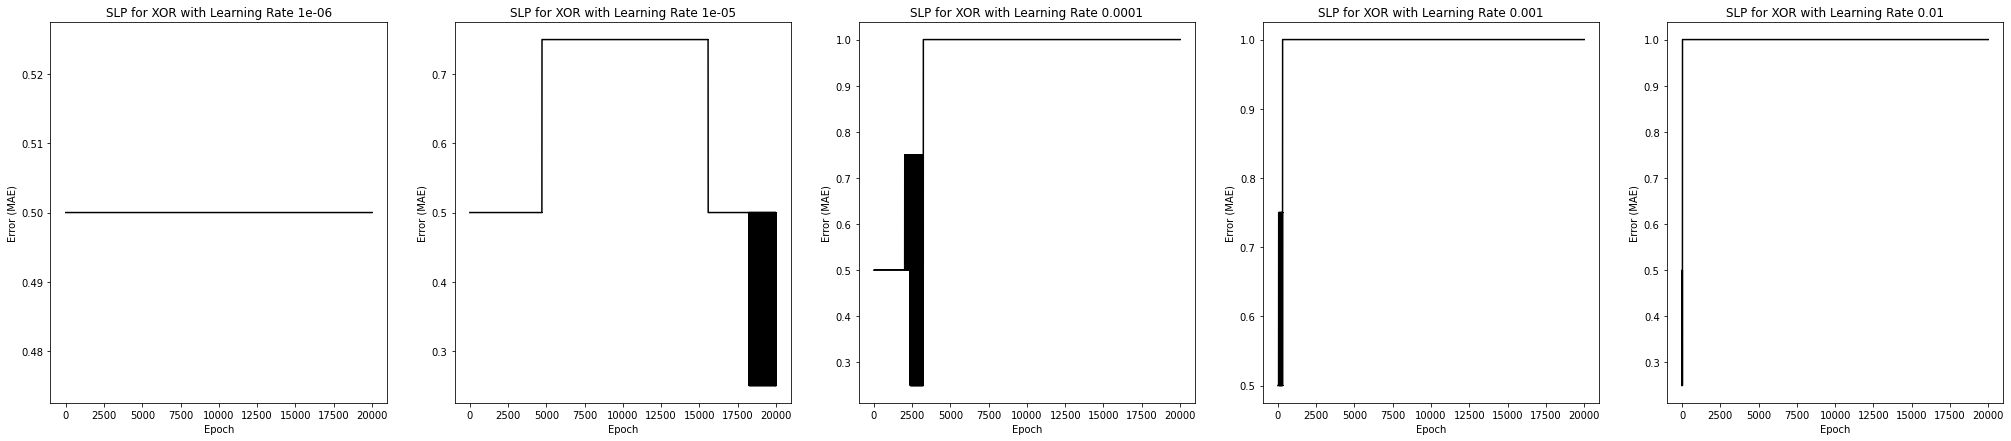

In [3]:
learning_rates = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

# SLPs for the XOR Problem
X, y = XOR()
lr_epochs = {
    'lr': learning_rates,
    'x': [i for i in range(1, 20001)],
    'y': list()
}
for lr in learning_rates:
  model = SLP(2, learning_rate=lr)
  error_vs_epoch = model.fit(X, y)
  lr_epochs["y"].append(error_vs_epoch)

plotting(lr_epochs, "XOR")

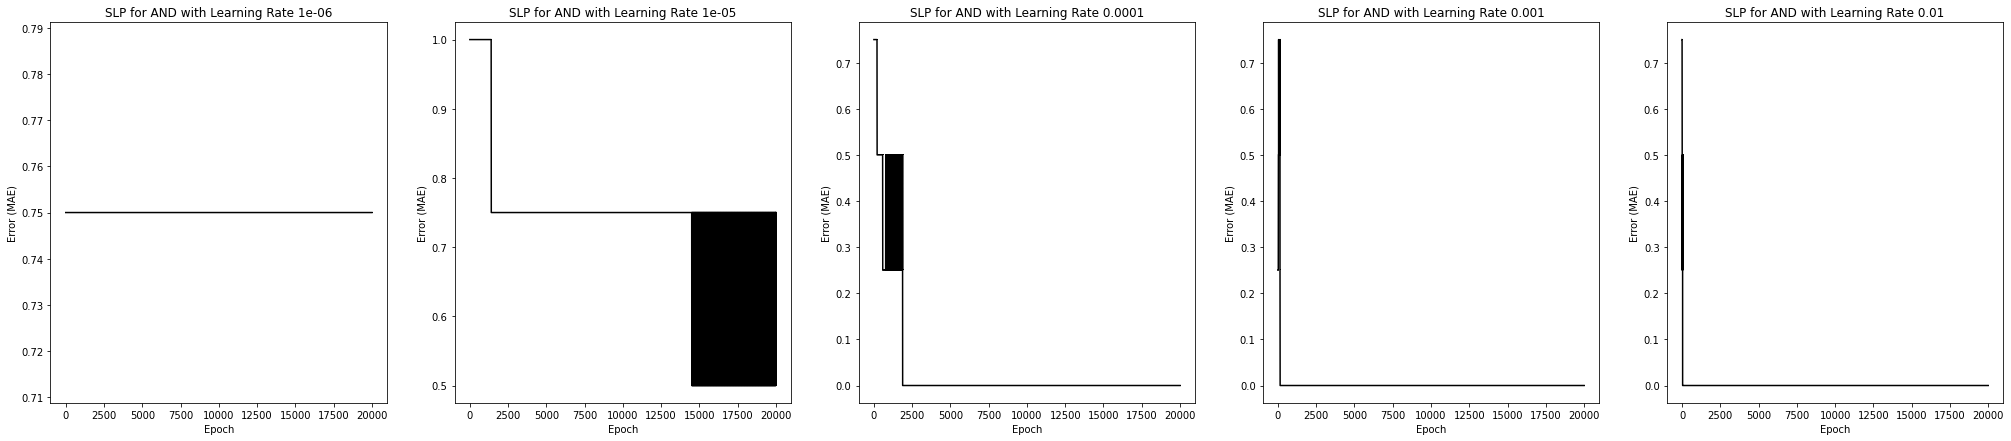

In [4]:
# SLPs for the AND Problem
X, y = AND()
lr_epochs = {
    'lr': learning_rates,
    'x': [i for i in range(1, 20001)],
    'y': list()
}
for lr in learning_rates:
  model = SLP(2, learning_rate=lr)
  error_vs_epoch = model.fit(X, y)
  lr_epochs["y"].append(error_vs_epoch)

plotting(lr_epochs, "AND")

### 2. Implement the Bayes classifier over the breast cancer wisconsin dataset.

In [5]:
class BayesClassifier():
  def __init__(self, features, classes):
    self._classes = classes
    self._features = features
    self._class_probs = np.zeros(shape=(classes, 1))
    self._distributions = np.zeros(shape=(classes, features, 2))

  def __separate_classes(self, X, Y):
    separated_classes = dict()
    for i in range(X.shape[0]):
      x = X[i]
      y = Y[i]
      if str(y) not in separated_classes:
        separated_classes[str(y)] = list()
      separated_classes[str(y)].append(x)
    return separated_classes

  def __calc_mean_stdev_class(self, X):
    mean_stdevs = np.zeros(shape=(self._features, 2))
    np.mean(X, axis=0, out=mean_stdevs[:, 0])
    np.std(X, axis=0, out=mean_stdevs[:, 1])
    return mean_stdevs

  def fit(self, X, y):
    separated_classes = self.__separate_classes(X, y)
    total = 0
    for i in range(self._classes):
      total += len(separated_classes[str(i)])
    for i in range(self._classes):
      self._class_probs[i] = len(separated_classes[str(i)]) / total
      self._distributions[i, :, :] = self.__calc_mean_stdev_class(separated_classes[str(i)])
  
  def __probability(self, x, mu, sigma):
	  return (1 / (sqrt(2 * pi) * sigma)) * exp((- (x - mu) ** 2)/(2 * sigma**2 ))

  def __predict_class(self, x):
    probs = np.ones(shape=(self._classes, 1))
    for i in range(self._classes):
      probs[i, 0] *= self._class_probs[i, 0]
      for j in range(self._features):
        probs[i, 0] *= self.__probability(x[j], self._distributions[i, j, 0], self._distributions[i, j, 1])

    return np.argmax(probs, axis=0)

  def predict(self, X):
    X = np.array(X)
    y = np.zeros(shape=(X.shape[0], 1))
    for i in range(X.shape[0]):
      y[i] = self.__predict_class(X[i])

    return y

  def accuracy(self, X, y):
    total = 0
    y_pred = self.predict(X)
    for i in range(len(y)):
      if y[i] == y_pred[i, 0]:
        total += 1
    return total / len(y)

In [6]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)

classifier = BayesClassifier(X.shape[1], 2)
classifier.fit(X_train, y_train)

accuracy = classifier.accuracy(X_test, y_test)

print(f"Accuracy on Test Set is {accuracy * 100: 1f} %")

Accuracy on Test Set is  92.105263 %
